In [1]:
import numpy as np 
import matplotlib.pyplot as plt
import pickle
from scipy.optimize import minimize
import geatpy as ea
import torch
import torch.nn as nn
import torch.optim as optim
plt.rcParams.update({'font.size': 15})
from torch.utils.data import DataLoader, TensorDataset

In [2]:
time_dur = 1000
Nsyn = 5

def kernel(tau_rise, tau_decay):
    T = np.arange(time_dur)
    y = (1 - np.exp(-T / tau_rise)) * np.exp(-T / tau_decay)
    return y

def model(X, Omega, Tau_rise, Tau_decay, K, v0):
    # X is one sample here
    Y = np.zeros(time_dur)
    L = np.zeros((Nsyn, time_dur))
    for i in range(Nsyn):
        ker = kernel(Tau_rise[i], Tau_decay[i])
        L[i] = Omega[i]*np.convolve(X[i], ker)[:time_dur]
        Y += L[i]
        if i > 0:
            for j in range(i):
                Y += -K[int(i*(i-1)/2)+j] * L[i] * L[j]
    return Y + v0

def hlm(X, Omega, Tau_rise, Tau_decay, K, v0):
    # X is the training set
    Y = np.empty((X.shape[0], time_dur))
    for i in range(X.shape[0]):
        Y[i] = model(X[i], Omega, Tau_rise, Tau_decay, K, v0)
    return Y

def model_l(X, Omega, Tau_rise, Tau_decay, v0):
    # X is one sample here
    Y = np.zeros(time_dur)
    L = np.zeros((Nsyn, time_dur))
    for i in range(Nsyn):
        ker = kernel(Tau_rise[i], Tau_decay[i])
        L[i] = Omega[i]*np.convolve(X[i], ker)[:time_dur]
        Y += L[i]
    return Y + v0

def hlm_l(X, Omega, Tau_rise, Tau_decay, v0):
    # X is the training set
    Y = np.empty((X.shape[0], time_dur))
    for i in range(X.shape[0]):
        Y[i] = model_l(X[i], Omega, Tau_rise, Tau_decay, v0)
    return Y

In [3]:
def generate_binary_spike_train(num_spikes, duration, dt):
    """
    Generate a binary spike train.

    Parameters:
    - num_spikes: Number of spikes in the train
    - duration: Duration of the spike train in seconds
    - dt: Time step in seconds

    Returns:
    - spike_train: Array of 0s and 1s where 1 indicates a spike
    """
    num_time_bins = int(duration / dt)
    spike_train = np.zeros(num_time_bins)

    # Generate spikes
    spike_times = np.random.choice(num_time_bins, num_spikes, replace=False)
    spike_train[spike_times] = 1

    return spike_train.astype(int)

In [14]:
num_tr_samples = 10000  # Total number of training samples
num_classes = 10  # Number of classes
num_features = 5  # Number of features per sample (dimensions)
duration = 1000  # Duration of the spike train (ms)
dt = 1  # Time step (ms)
num_spikes = 20 # Number of spikes per feature

# Initialize empty arrays for data and labels
X_tr = np.zeros((num_tr_samples, num_features, duration))  # Training set
labels_tr = np.zeros(num_tr_samples, dtype=int)  # Labels

# Define which two dimensions are correlated in each class
related_features = [(0, 1), (0, 2), (1, 2), (0, 3), (1, 3), (2, 3), (0, 4), (1, 4), (2, 4), (3, 4)]

# Generate data
for i in range(num_tr_samples):
    class_label = i % num_classes  # Assign a class label (0-9) for each sample
    rel_feat = related_features[class_label]  # Get the indices of correlated features
    
    # Generate other non-correlated features
    for feat in range(num_features):
        if feat not in rel_feat:
            X_tr[i, feat] = generate_binary_spike_train(num_spikes, duration, dt)
    
    # Generate correlated features
    base_value = generate_binary_spike_train(num_spikes, duration, dt)
    X_tr[i, rel_feat[0]] = base_value
    X_tr[i, rel_feat[1]] = base_value # The second feature is the same as the first one
    
    labels_tr[i] = class_label

In [28]:
Vars1 = np.array([1.5, 1.5, 1.5, 1.5, 1.5,
                 2, 2, 2, 2, 2,
                 20, 20, 20, 20, 20,
                 .1, 
                 .2, .3, 
                 .4, .5, .6, 
                 .7, .8, .9, 1.0, 
                 0])

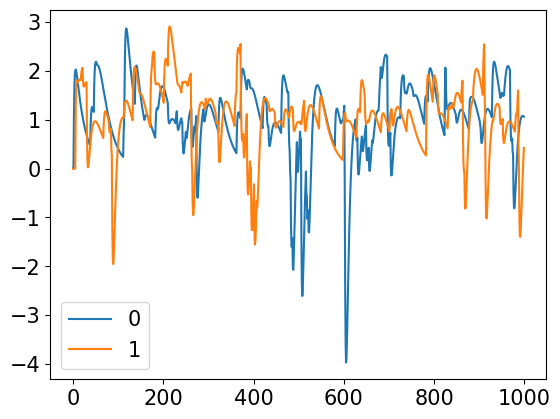

In [29]:
V1 = model(X_tr[0], Vars1[0:5], Vars1[5:10], Vars1[10:15], Vars1[15:25], Vars1[25])
V2 = model(X_tr[1], Vars1[0:5], Vars1[5:10], Vars1[10:15], Vars1[15:25], Vars1[25])
plt.plot(V1, label='0')
plt.plot(V2, label='1')
plt.legend()

In [30]:
np.mean(V1), np.mean(V2)

(1.0197844491605008, 1.0508859269676545)

In [31]:
V = hlm(X_tr, Vars1[0:5], Vars1[5:10], Vars1[10:15], Vars1[15:25], Vars1[25])

In [32]:
mean_V = np.mean(V, axis=1)
mean_V.shape

(10000,)

In [33]:
M = np.zeros((10, 1000))
for i in range(len(mean_V)):
    id = i % 10
    num = i // 10
    M[id, num] = mean_V[i]

In [34]:
p = np.mean(M, axis=1)
p.shape

(10,)

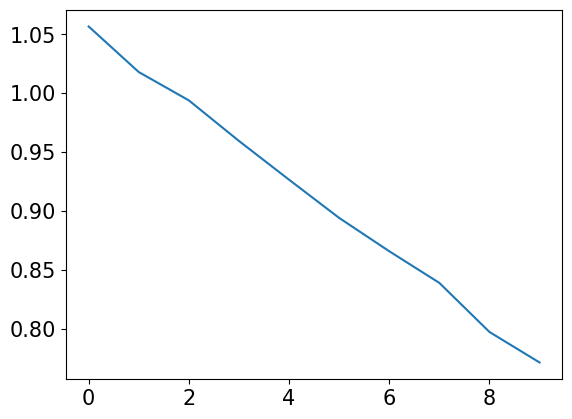

In [36]:
plt.plot(p)

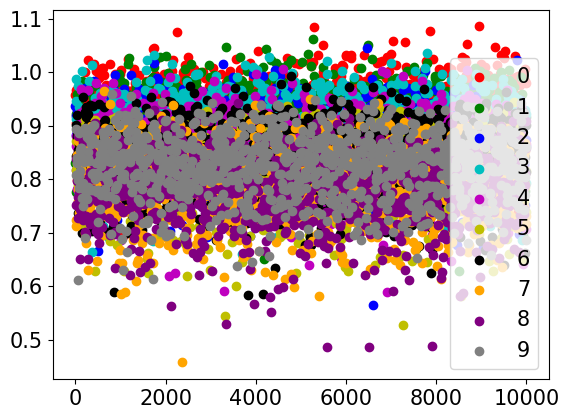

In [39]:
# 按照 mod10 进行分类
colors = ['r', 'g', 'b', 'c', 'm', 'y', 'k', 'orange', 'purple', 'gray']
labels = np.mod(np.arange(len(mean_V)), 10)

# 画散点图
fig, ax = plt.subplots()
for i in range(10):
    ax.scatter(np.arange(len(mean_V))[labels==i], mean_V[labels==i], c=colors[i], label=str(i))
ax.legend()
plt.show()